In [68]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from typing import Tuple, Union, List
import matplotlib.pyplot as plt

random_state = 88844
rng = np.random.default_rng(seed=random_state)

data = load_breast_cancer()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]
target_names = data["target_names"]

print(X.shape, y.shape)
print("Target classes:", target_names)


(569, 30) (569,)
Target classes: ['malignant' 'benign']


# Baseline model

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, log_loss

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_test.shape}")

pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

pipe.fit(X_train, y_train)

y_test_preds = pipe.predict(X_test)
# print("loss: ", log_loss(y_test, pipe[1].predict_proba(X_test)))

print(classification_report(y_test, y_test_preds))


X_train size: (455, 30)
X_test size: (114, 30)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.97      0.99      0.98        69

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



# Implementing the same model using `flower`

## Ingredients:
1. Split the data into $n$ datasets, each representing a different location where the data lives
2. Define functions for:
    - Getting model parameters
    - Setting model parameters
3. Define `FlowerClient` 
    - Should contain the following:
        - `get_parameters`
        - `fit`
        - `evaluate`
4. Set Federated learning strategy
6. Simulate!

## 1. Data setup
Since we have ~450 training instances, let's say we have $n=5$ different hospitals where the breast cancer data lives

In [3]:
def split_dataset(
    X: np.array, y: np.array, n_clients: int = 5
) -> List[Tuple[np.array, np.array]]:
    n_clients = 5
    partition_sizes = len(X) // n_clients

    partition_indices = rng.choice(
        len(X), size=(n_clients, partition_sizes), replace=False
    )
    sets = [(X[pidx], y[pidx]) for pidx in partition_indices]
    return sets


train_sets = split_dataset(X_train, y_train)
train_sets[0][0].shape, train_sets[0][1].shape  # Number of samples for our first client



((91, 30), (91,))

We'll have a single test set shared across all clients

In [4]:
test_set = (X_test, y_test)

## 2. Fetching/reloading model parameters
Taken from the `flower` [sklearn example](https://github.com/adap/flower/blob/main/examples/sklearn-logreg-mnist/utils.py)

**Notes:**
- `get_model_params` needs to return a list of parameters
    - It doesn't seem to allow for List of Lists of different sizes (i.e. ragged arrays)
    - such lists throw an error when fitting
- `set_initial_params` initializes the StdScaler and LogReg parameters to zero
    - An alternative approach would be to fit the model on a dummy dataset that has the same shape as the training data


In [26]:
from sklearn.pipeline import Pipeline

def get_model_parameters(pipe: Pipeline) -> dict:
    params = [
        pipe[0].scale_, pipe[0].mean_, pipe[0].var_,
        pipe[1].coef_
    ]
       
    if pipe[1].fit_intercept:
        params.append(pipe[1].intercept_)

    return params


def set_model_params(pipe: Pipeline, params) -> Pipeline:
    """Since we're working wiht a pipeline object, we need to set
    the parameters for all underlying models. In this case a scaler and LogisticRegression.
    """
    # unpack scaler parameters
    pipe[0].scale_, pipe[0].mean_, pipe[0].var_ = params[:3]

    if pipe[1].fit_intercept:
        pipe[1].coef_, pipe[1].intercept_ = params[3:]
    else:
        pipe[1].coef_ = params[-1]
    return pipe


def set_initial_params(pipe: Pipeline, n_feats, n_classes=1) -> Pipeline:
    pipe[0].scale_ = np.zeros(shape=(n_feats))
    pipe[0].mean_ = np.zeros(shape=(n_feats))
    pipe[0].var_ = np.zeros(shape=(n_feats))
    pipe[0].n_samples_seen_ = np.zeros(shape=(n_feats))

    pipe[1].classes_ = np.arange(n_classes)
    pipe[1].coef_ = np.zeros(shape=(n_classes, n_feats))
    if pipe[1].fit_intercept:
        pipe[1].intercept_ = np.zeros(shape=(n_classes))
    # return pipe

## 3. Define FlowerClient

In [30]:
import warnings
import flwr as fl

class BreastCancerClient(fl.client.NumPyClient):
    def __init__(self, pipe, train_set, test_set):
        self.pipe = pipe
        self.clf = self.pipe.steps[-1][1]
        self.X_train, self.y_train = train_set
        self.X_test, self.y_test = test_set

    def get_parameters(self, config):
        return get_model_parameters(self.pipe)

    def fit(self, parameters, config):
        set_model_params(self.pipe, parameters)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.pipe.fit(self.X_train, self.y_train)

        # print(f"Training finished for round {config['server_round']}")
        return self.get_parameters(self.pipe), len(self.X_train), {}

    def evaluate(self, parameters, config):  # type: ignore
        set_model_params(self.pipe, parameters)
        loss = log_loss(self.y_test, self.clf.predict_proba(self.X_test))
        accuracy = self.clf.score(self.X_test, self.y_test)
        return loss, len(self.X_test), {"accuracy": accuracy}

def launch_client(client_id, train_sets=train_sets, test_set=test_set):
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1, warm_start=True))
    train_set = train_sets[int(client_id)]
    set_initial_params(model, n_feats=(train_set[0][0].shape[-1]), n_classes=1)
    return BreastCancerClient(model, train_set, test_set)

## 5. Set Federated learning strategy


To keep track of the client side accuracy, we implement a `mean_accuracy` function.

The `metrics` input to this function is a list of the form: `[(n_examples, dict(metric_name, value))]`, where `n_examples` is the number of examples seen by the client in a training round.

In [77]:
from flwr.common import Metrics

# Implement function to print mean accuracy across clients
def mean_accuracy(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [m["accuracy"] for n_examples, m in metrics]
    return {"accuracy": np.mean(accuracies)}

def weighted_accuracy(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,
    min_evaluate_clients=1,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
    # evaluate_metrics_aggregation_fn=mean_accuracy
    evaluate_metrics_aggregation_fn=weighted_accuracy
)

## 6. Simulate!

In [78]:
n_rounds = 5
hist = fl.simulation.start_simulation(
    client_fn=launch_client,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=n_rounds),
    strategy=strategy,
    client_resources=None,    
)

INFO flwr 2023-04-30 16:16:02,711 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-30 16:16:07,364	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-04-30 16:16:10,402 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'memory': 11710201038.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 5855100518.0}
INFO flwr 2023-04-30 16:16:10,404 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-30 16:16:10,404 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-04-30 16:16:11,169 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-04-30 16:16:11,170 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-30 16:16:11,170 | server.py:101 | FL starting
DEBUG flwr 2023-04-30 16:16:11,171 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-04-30 16:16:11,974 | server.py:2

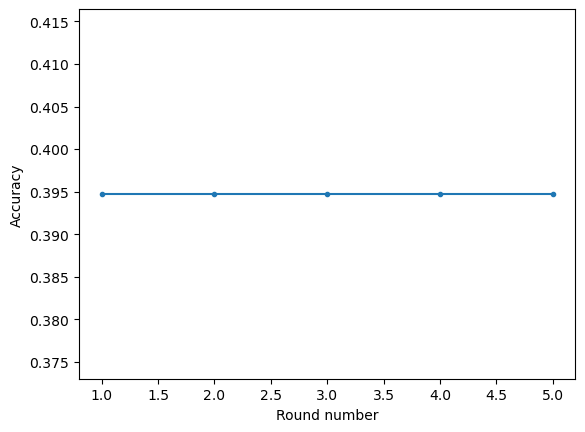

In [79]:
dist_acc = [acc for round_n, acc in hist.metrics_distributed["accuracy"]]

plt.plot(range(1, n_rounds+1), dist_acc, ".-", label="accuracy")
plt.xlabel("Round number")
plt.ylabel("Accuracy")
plt.show()
